<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_PySR_Steel_BM_G1_correction_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

In [3]:
%pip install julia

In [4]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

In [1]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/steel_i.csv')

In [3]:
print(df.head(5))

                                       model girderName  radius   L       D  \
0  PG-1-L_60-Nb_4-S_60-O_10-ts_85-sk_0-R_300       PG-1     300  60  21.875   
1  PG-1-L_60-Nb_4-S_60-O_16-ts_85-sk_0-R_300       PG-1     300  60  21.875   
2  PG-1-L_60-Nb_4-S_60-O_23-ts_85-sk_0-R_300       PG-1     300  60  21.875   
3  PG-1-L_60-Nb_4-S_60-O_30-ts_85-sk_0-R_300       PG-1     300  60  21.875   
4  PG-1-L_60-Nb_4-S_90-O_10-ts_85-sk_0-R_300       PG-1     300  60  21.875   

       w_oh   ts  S  Nb        I  ...  n_bm4   n_r1   n_r2   n_r3   n_r4  \
0  1.000000  8.5  6   4  3212.29  ...    0.0  0.893  0.242  0.115 -0.220   
1  1.666667  8.5  6   4  3212.29  ...    0.0  0.964  0.196  0.117 -0.244   
2  2.333333  8.5  6   4  3212.29  ...    0.0  1.035  0.151  0.118 -0.269   
3  3.000000  8.5  6   4  3212.29  ...    0.0  1.107  0.106  0.118 -0.293   
4  1.000000  8.5  9   4  3212.29  ...    0.0  0.917  0.224  0.067 -0.162   

   sum_RY   d-G1   d-G2   d-G3  d-G4  
0   1.808  0.501  0.309  0.14

In [6]:
df_straight = df[df['radius'] == 10000]
df_curved = df[df['radius'] != 10000]

In [43]:
L = df_curved['L']
D = df_curved['D']
S = df_curved['S']
girderName = df_curved['girderName']
w_oh = df_curved['w_oh']
ts = df_curved['ts']
Nb = df_curved['Nb']
Kg = df_curved['Kg']
I = df_curved['I']
R = df_curved['radius']
R1 = R + (Nb / 2.0 - 0.5) * S
L_R = L / R
n_bm1 = df_curved['n_bm1']
O = (df_curved['w_oh'] * 10).astype(int)
ts = (df_curved['ts'] * 10).astype(int)
models = girderName + '-L_' + L.astype(str) + '-Nb_' + Nb.astype(str) + '-S_' + (S*10).astype(str) + '-O_' + O.astype(str) + '-ts_' + ts.astype(str) + '-sk_0-R_'

n_bm1_R_10000 = df.loc[(df['radius'] == 10000) , 'n_bm1'].values
n_bm1_R_1000 = df.loc[(df['radius'] == 1000) , 'n_bm1'].values
n_bm1_R_300 = df.loc[(df['radius'] == 300) , 'n_bm1'].values
radii = [1000, 300]
R_bm1_correction = []
x_L = []
x_S = []
x_Nb = []
x_R = []
x_w_oh = []
for model in models:
  for radius in radii:
    curved_girder_model = model + str(radius)
    straight_girder_model = model + str('10000')
    n_bm1_curved = df_curved.loc[(df_curved['model'] == curved_girder_model) , 'n_bm1'].values
    n_bm1_straight = df_straight.loc[(df_straight['model'] == straight_girder_model) , 'n_bm1'].values
    R_bm1_correction.extend(n_bm1_curved / n_bm1_straight)
    x_L.extend(df_curved.loc[(df_curved['model'] == curved_girder_model) , 'L'].values)
    x_S.extend(df_curved.loc[(df_curved['model'] == curved_girder_model) , 'S'].values)
    x_Nb.extend(df_curved.loc[(df_curved['model'] == curved_girder_model) , 'Nb'].values)
    x_R.extend(df_curved.loc[(df_curved['model'] == curved_girder_model) , 'radius'].values)
    x_w_oh.extend(df_curved.loc[(df_curved['model'] == curved_girder_model) , 'w_oh'].values)

print(R_bm1_correction)
print(x_L)

[1.02734375, 1.091796875, 1.0260707635009312, 1.0912476722532587, 1.0267379679144384, 1.0909090909090908, 1.0273972602739727, 1.0907534246575343, 1.0286677908937605, 1.1011804384485666, 1.028436018957346, 1.0995260663507107, 1.028315946348733, 1.0998509687034277, 1.0282485875706215, 1.1002824858757063, 1.033639143730887, 1.117737003058104, 1.0338504936530324, 1.1184767277856136, 1.0341655716162943, 1.1195795006570302, 1.0344827586206895, 1.1206896551724137, 1.0267175572519085, 1.0935114503816792, 1.0273224043715845, 1.0928961748633879, 1.0261324041811848, 1.0905923344947737, 1.0268006700167505, 1.0904522613065328, 1.0298507462686568, 1.1011608623548923, 1.0279503105590062, 1.0993788819875776, 1.0293255131964807, 1.1011730205278591, 1.0291666666666668, 1.101388888888889, 1.033132530120482, 1.1174698795180722, 1.0333796940194715, 1.118219749652295, 1.033678756476684, 1.1191709844559585, 1.0351941747572815, 1.121359223300971, 1.0281954887218046, 1.0977443609022555, 1.0268336314847941, 1.0

In [44]:
X = np.stack((x_L, x_S, x_w_oh, x_Nb, x_R), axis=-1)
y = R_bm1_correction
print(X.shape)
print(y.shape)

(5952, 5)


AttributeError: 'list' object has no attribute 'shape'

In [45]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=300,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


Streaming output truncated to the last 5000 lines.
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.379e-03  1.594e+01  y = 1.1065
3           4.198e-03  2.113e-02  y = x₀ ^ 0.023282
4           4.022e-03  4.288e-02  y = square(1.0006 ^ x₀)
5           8.664e-04  1.535e+00  y = (50.808 / x₄) + 0.99644
6           5.447e-04  4.641e-01  y = sqrt(x₄ / (x₄ - x₀))
7           3.525e-04  4.351e-01  y = 0.9973 + ((x₀ ^ 0.89184) / x₄)
9           2.631e-04  1.463e-01  y = 0.99576 + (((x₀ / 1.9274) + x₁) / x₄)
10          2.342e-04  1.163e-01  y = sqrt((x₀ / (x₄ - (x₁ * x₃))) + 1.0214)
11          2.130e-04  9.473e-02  y = ((x₀ / (x₄ - (x₃ * x₁))) + 1.0154) ^ 0.52584
12          1.394e-04  4.243e-01  y = sqrt(((x₀ + ((x₃ - 1.858) * x₁)) / x₄) + 0.98199)
14          1.319e-04  2.740e-02  y = sqrt((x₀ / (x₄ - physics(x₁ * (x₃ * 1.2094), x₀))) + 1.019...
                        

In [119]:
n = 9
model.sympy(n)

sqrt(0.98199373 + (x0 + x1*(x3 - 1.8579929))/x4)

In [120]:
R_bm1_correction_pred = model.predict(X,n)

print("Default selection MSE:", np.power(R_bm1_correction_pred - R_bm1_correction, 2).mean())

Default selection MSE: 0.00013937097295486895


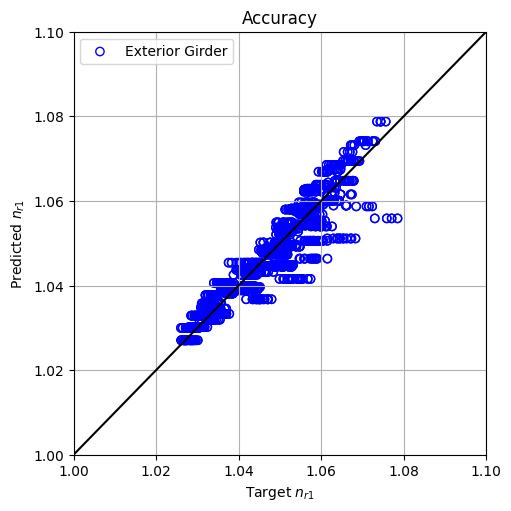

In [121]:
x_line = [0.9, 1.2]
y_line = [0.9, 1.2]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=R_bm1_correction, y=R_bm1_correction_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((1.0,1.1))
plt.ylim((1.0,1.1))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [122]:
model.latex(n)

'\\sqrt{0.982 + \\frac{x_{0} + x_{1} \\left(x_{3} - 1.86\\right)}{x_{4}}}'

In [123]:
print(X[0])

[  60.    6.    1.    4. 1000.]
